<a href="https://colab.research.google.com/github/a-garnier/ASDpy/blob/antoine/asdpy_auto_encoder_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

# http://dcase.community/documents/workshop2020/proceedings/DCASE2020Workshop_Perez-Castanos_15.pdf
# normalise les données ( normalization of zero mean and standard deviation of one is performed for each frequen)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

from joblib import dump, load

%matplotlib inline


In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
def loadMatrixDataframes(machines, sets):
  dataFolder = '/drive/MyDrive/asdpy/data/original/dc2020task2'
  partial_dataframes = []

  for machine in machines:
      for s in sets:
          saveName = dataFolder+'/'+machine+'/df_'+machine+'_128_64_'+s+'.joblib'
          partial_dataframe = load(saveName)
          print(partial_dataframe.head(5))
          partial_dataframes.append(partial_dataframe)

  # concatenate all partials dataframes on horizontal axis
  return pd.concat(partial_dataframes, axis=1)

In [ ]:
# transform the matrices in vectors
def toVector(matrix):
  return np.reshape(matrix, (len(matrix), 64*128))

# transform the vectors in machines
def toMatrix(vector):
  return np.reshape(vector, (len(vector), 64, 128, 1))

def normalize(scaler, matrix):
  return scaler.transform(matrix)
  #return matrix
  #vector = toVector(matrix)
  #vector_scaled = scaler.transform(vector)
  #matrix_scaled = toMatrix(vector_scaled)
  #return matrix_scaled

def unnormalize(scaler, matrix_scaled):
  #return scaler.inverse_transform(matrix_scaled)
  #return matrix_scaled
  vector_scaled = toVector(matrix_scaled)
  vector = scaler.inverse_transform(vector_scaled)
  matrix = toMatrix(vector)
  return matrix

def resizeForModel(matrix):
  #return matrix
  return toVector(matrix)

def resizeForDisplay(matrix):
  return matrix
  #return toMatrix(matrix)

In [ ]:
# load training datas
machines = ['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

# concatenate all dataframes as one
dataframe = loadMatrixDataframes(['fan'], ['train'])

#print(matrix)
print(dataframe.head(5))
#print(matrix.dtypes)

pixels = dataframe.iloc[: , 1:-1]
pixels = np.log(pixels + 1e-9)

# normalize matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(pixels)
pixels = normalize(scaler, pixels)

#pixels = np.reshape(pixels.to_numpy(), (3675, 128, 64, 1))
pixels = np.reshape(pixels, (3675, 128, 64, 1))

anomalies = dataframe.iloc[: , -1]

print(pixels.shape)
print(anomalies.shape)


#matrix_scaled = toVector(matrix)

# split for training
from sklearn.model_selection import train_test_split
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(pixels, anomalies, test_size=0.33, random_state=42)


print(X_train_scaled.shape)
print(X_test_scaled.shape)

# spare RAM
del dataframe
del pixels
del anomalies

                                                0         1     ...      8192  8193
0  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.081388  ...  0.008966     0
1  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.091497  ...  0.004943     0
2  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.341905  ...  0.002035     0
3  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.112333  ...  0.002218     0
4  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.166616  ...  0.002301     0

[5 rows x 8194 columns]
                                                0         1     ...      8192  8193
0  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.081388  ...  0.008966     0
1  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.091497  ...  0.004943     0
2  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.341905  ...  0.002035     0
3  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.112333  ...  0.002218     0
4  /drive/MyDrive/asdpy/data/original/dc2020task2..

In [ ]:
# Create the Encoder and Decoder
#pass the gray scale input image of size(128,313,1)
inputs = tf.keras.Input(shape=(128, 64, 1), name='input_layer')
#inputs = tf.keras.Input(shape=(40064, 1, 1), name='input_layer')

# strides: va diviser les dimensions de l'image par la valeur

strides_1 = (2,2);
strides_2 = (2,2);

# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)

# Conv Block 2 -> BatchNorm->leaky Relu => divide by 2
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=strides_1, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)

# Conv Block 3 -> BatchNorm->leaky Relu => divide by 2
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides=strides_2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

# Conv Block 4 -> BatchNorm->leaky Relu => divide by 2
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides=strides_2, padding='same', name='conv_4')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(encoded)

#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides=1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)

# DeConv Block 2-> BatchNorm->leaky Relu => multiply by 2
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides=strides_2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

# DeConv Block 3-> BatchNorm->leaky Relu => multiply by 2
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides=strides_1, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_7')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_7')(decoded)

# DeConv Block 4-> BatchNorm->leaky Relu => multiply by 2
decoded = tf.keras.layers.Conv2DTranspose(32, 3, strides=strides_1, padding='same', name='conv_transpose_4')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_8')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_8')(decoded)

# output
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_5')(decoded)

In [ ]:
# test with dense
from keras import layers

pixels = 64*128
dimension = (pixels, )

inputs = tf.keras.Input(shape=dimension)

encoded = layers.Dense(pixels, activation='relu')(inputs)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

outputs = layers.Dense(64, activation='relu')(encoded)
outputs = layers.Dense(128, activation='relu')(outputs)
outputs = layers.Dense(pixels, activation='sigmoid')(outputs)

In [ ]:
#input Layer

pixels = 128*64
#dimension = (pixels, 1)

input_dim = pixels
#input_dim = (128, 64, 1) #pas possible de passer un tuple

encoding_dim = pixels
hidden_dim_1 = int(encoding_dim / 4) #
hidden_dim_2= int(hidden_dim_1 / 4) #  
learning_rate = 1e-7

inputs = tf.keras.layers.Input(shape=(input_dim, ))

#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(learning_rate))(inputs)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
                                                                           
# Decoder
outputs = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
outputs = tf.keras.layers.Dropout(0.2)(outputs)
outputs = tf.keras.layers.Dense(encoding_dim, activation='relu')(outputs)
outputs = tf.keras.layers.Dense(input_dim, activation='tanh')(outputs)

#Autoencoder
model = tf.keras.Model(inputs=inputs, outputs=outputs)
#optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(optimizer=optimizer, loss="mse")
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 8192)]            0         
_________________________________________________________________
dense_66 (Dense)             (None, 8192)              67117056  
_________________________________________________________________
dropout_22 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_67 (Dense)             (None, 2048)              16779264  
_________________________________________________________________
dense_68 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_69 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dropout_23 (Dropout)         (None, 2048)              0  

In [ ]:
def SSIMLoss(y_true, y_pred):
  #print(y_true.shape)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))
  #return tf.math.reduce_euclidean_norm(tf.image.ssim(y_true, y_pred,1.0)) # n'importe quoi
  

In [ ]:
model = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005)
model.compile(optimizer=optimizer, loss=SSIMLoss)
#model.compile(optimizer=optimizer, loss='mean_squared_error') # n'importe quoi

model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 8192)]            0         
_________________________________________________________________
dense_54 (Dense)             (None, 8192)              67117056  
_________________________________________________________________
dropout_18 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 2048)              16779264  
_________________________________________________________________
dense_56 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_57 (Dense)             (None, 2048)              1050624   
_________________________________________________________________
dropout_19 (Dropout)         (None, 2048)              0  

In [ ]:
# sans CPU : 
# avec TPU : modif particulière requise
# avec GPU : 12 secondes par epoch
# 25 epochs : val_loss: 0.45
# 50 epochs : val_loss: 0.12
# 75 epochs : val_loss: 0.106
# 100 epochs : val_loss: 0.093
hist=model.fit(resizeForModel(X_train_scaled), resizeForModel(X_train_scaled),
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(resizeForModel(X_test_scaled), resizeForModel(X_test_scaled))
                )

Epoch 1/50
20/20 [==============================] - 3s 140ms/step - loss: 0.6637 - val_loss: 0.5135
Epoch 2/50
20/20 [==============================] - 2s 123ms/step - loss: 0.4884 - val_loss: 0.4572
Epoch 3/50
20/20 [==============================] - 2s 122ms/step - loss: 0.4539 - val_loss: 0.4398
Epoch 4/50
20/20 [==============================] - 2s 122ms/step - loss: 0.4368 - val_loss: 0.4304
Epoch 5/50
20/20 [==============================] - 2s 122ms/step - loss: 0.4300 - val_loss: 0.4294
Epoch 6/50
20/20 [==============================] - 2s 122ms/step - loss: 0.4219 - val_loss: 0.4231
Epoch 7/50
20/20 [==============================] - 2s 122ms/step - loss: 0.4159 - val_loss: 0.4180
Epoch 8/50
20/20 [==============================] - 2s 122ms/step - loss: 0.4093 - val_loss: 0.4152
Epoch 9/50
20/20 [==============================] - 2s 124ms/step - loss: 0.4043 - val_loss: 0.4145
Epoch 10/50
20/20 [==============================] - 2s 122ms/step - loss: 0.4027 - val_loss: 0.4163

In [ ]:
# save model
import pickle

dataFolder = '/drive/MyDrive/asdpy/data/tests/auto_encoder_2'
saveName = dataFolder+'/hist.pickle'
print(saveName)

with open(saveName, 'wb') as f:
    pickle.dump(hist.history, f)
    

/drive/MyDrive/asdpy/data/tests/auto_encoder_2/hist.pickle


In [ ]:
import random

# function for result display
def show_spectrograms(original, reconstructed, anomalies, n):  


  #print(type(original))
  #print(type(reconstructed))

  #print(original.shape)
  #print(reconstructed.shape)

  plt.figure(figsize=(10, 7), dpi=100)
  plt.subplots_adjust( wspace=0.1, hspace=0.07)
  plt_a=1

  for i in range(n):
      j = random.randrange(len(original))

      #print(j)
      #img_original = original.iloc[j].to_numpy().reshape(64, 128)
      #img_reconstructed = reconstructed.iloc[j].to_numpy().reshape(64, 128)
      img_original = original[j].reshape(64, 128)
      img_reconstructed = reconstructed[j].reshape(64, 128)

      #img_original

      #img_original = np.log(img_original + 1e-9)
      #img_reconstructed = np.log(img_reconstructed + 1e-9)
      
      # Original training dataset vs Original training
      ax = plt.subplot(3, n, plt_a   )
      plt.imshow(img_original)
      plt.gray()
      ax.get_xaxis().set_visible(True)
      ax.get_yaxis().set_visible(False)
      ax.set_title("Original")
      
      # Reconstructed good data  vs Original training data
      ax = plt.subplot(3, n, plt_a + n )
      plt.imshow(img_reconstructed)
      plt.gray()
      ax.get_xaxis().set_visible(True)
      ax.get_yaxis().set_visible(False)    

      #print(type(img_original))
      #print(type(img_reconstructed))

      #print(img_original.shape)
      #print(img_reconstructed.shape)

      difference_array = np.subtract(original[j], reconstructed[j])
      squared_array = np.square(difference_array)
      mse = squared_array.mean()

      #print(mse)

      value = SSIMLoss(img_original.reshape(64, 128, 1), img_reconstructed.reshape(64, 128, 1))
      label = "SSIM Loss value: {:.3f}\nMSE: {:.3f}"
      ax.set_xlabel(label.format(value, mse) )

      #print("check anomaly")
      if anomalies.iloc[j]:
      #if anomalies[j]:
        title = "Anomaly"
      else:
        title = "Normal"

      ax.set_title(title)
      #ax.set_xlabel(label.format(value, mse))
      
      plt_a+=1

  plt.show()


In [ ]:
# encode/decode test set
y_test_pred_scaled = model.predict(resizeForModel(X_test_scaled))

# unscale image
y_test_pred = unnormalize('scaler', y_test_pred_scaled)

In [ ]:
# load training datas
machines = ['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

# concatenate all dataframes as one
dataframe = loadMatrixDataframes(['fan'], ['test'])

#print(matrix)
print(dataframe.head(5))
#print(matrix.dtypes)

X_validation = dataframe.iloc[: , 1:-1]
X_validation = np.log(X_validation + 1e-9)
X_validation = normalize(scaler, X_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], 128, 64, 1))
y_validation = dataframe.iloc[: , -1]

print(X_validation.shape)
print(y_validation.shape)

# normalize matrix
#X_validation_scaled = normalize('scaler', X_validation)

# encode/decode validation set
y_validation_pred_scaled = model.predict(resizeForModel(X_validation))

# unnormalize image
y_validation_pred = unnormalize(scaler, y_validation_pred_scaled)

                                                0         1     ...      8192  8193
0  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.156506  ...  0.001356     1
1  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.087758  ...  0.001331     1
2  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.109541  ...  0.002253     1
3  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.218811  ...  0.001151     1
4  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.193618  ...  0.001182     1

[5 rows x 8194 columns]
                                                0         1     ...      8192  8193
0  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.156506  ...  0.001356     1
1  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.087758  ...  0.001331     1
2  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.109541  ...  0.002253     1
3  /drive/MyDrive/asdpy/data/original/dc2020task2...  0.218811  ...  0.001151     1
4  /drive/MyDrive/asdpy/data/original/dc2020task2..

(64, 128, 1)
(64, 128, 1)
(64, 128, 1)


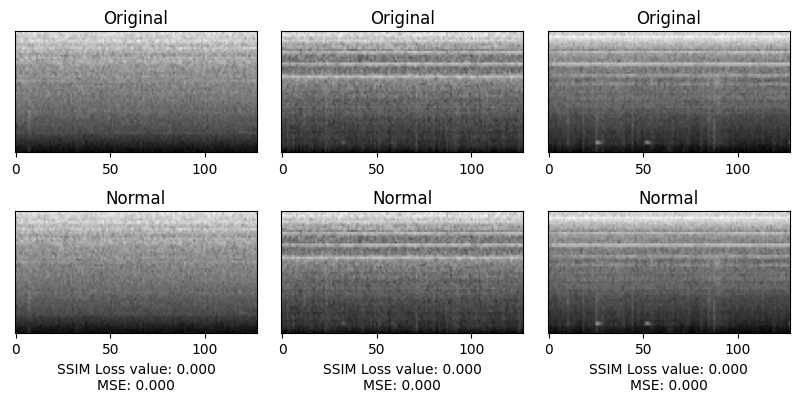

In [ ]:
# 1) same normal image
#X_test_unscaled = normalize(scaler, X_test_scaled)
X_test_unscaled = unnormalize(scaler, X_test_scaled)

# reconstucted image is an exact copy of the original: SSIM Loss is null
show_spectrograms(X_test_unscaled, X_test_unscaled, y_test, 3)

(64, 128, 1)
(64, 128, 1)
(64, 128, 1)


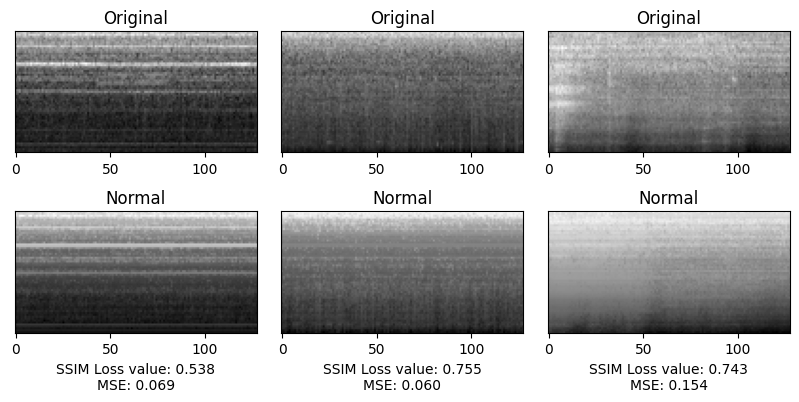

In [ ]:
# 2) top is original image, bottom is image reconstructed by autoencoder (test set, normal sounds) 
y_test_pred_unscaled = unnormalize(scaler, y_test_pred.astype('double'))
show_spectrograms(X_test_unscaled, y_test_pred_unscaled, y_test, 3)

(64, 128, 1)
(64, 128, 1)
(64, 128, 1)


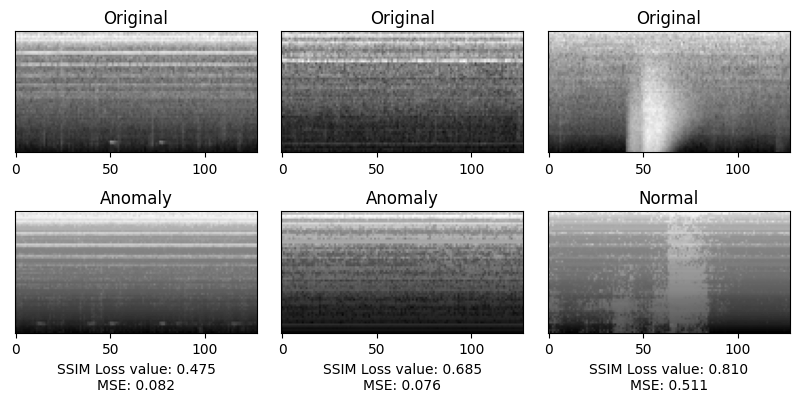

In [ ]:
# 2) top is original image, bottom is image reconstructed by autoencoder (validation set, normal and anomalous sounds) 
X_validation_unscaled = unnormalize(scaler, X_validation)

show_spectrograms(X_validation_unscaled, y_validation_pred.astype('double'), y_validation, 3)